<a href="https://colab.research.google.com/github/abubakarali3/Multiclass-Classification/blob/main/102Flowers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
pwd

'/content/gdrive/My Drive/Kaggle'

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [ ]:
# #changing the working directory
%cd ./gdrive/My Drive/Kaggle
# #Check the present working directory using pwd command

/content/gdrive/My Drive/Kaggle


In [ ]:
! kaggle competitions download -c oxford-102-flower-pytorch

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
!unzip \*.zip & rm * .zip

In [ ]:
cd './gdrive/MyDrive/Kaggle'

/content/gdrive/MyDrive/Kaggle


In [ ]:
ls

 archive/           kaggle.json            'test_sentences (1).csv'
 captions.txt       __pycache__/           'test_sentences (2).csv'
 cat_to_name.json   sample_submission.csv  'test_sentences (3).csv'
 CFC                sampleSubmission.csv    test_sentences.csv
 flickr8k.zip       state_dict.pt           training_labels.csv
 flower_data/       test1/                 'train_labels (1).csv'
 flower_data.zip    test1.zip               train_labels.csv
 GFG               'test_labels (1).csv'    train_sentences.csv
 helper.py         'test_labels (2).csv'    train.zip
 Images/           'test_labels (3).csv'
'kaggle (1).json'   test_labels.csv


In [ ]:
# Imports here
%matplotlib inline
import torch
import torchvision

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import helper
import pandas as pd
import time
import datetime
import re
import copy

from torch import nn, optim
from torchvision import datasets, transforms, models
from pathlib import Path
from PIL import Image

In [ ]:
import os
pwd = os.getcwd()

In [ ]:
data_dir = pwd+'/flower_data'

if Path.exists(Path(data_dir)):
    data_transforms = {
        'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomRotation(30),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(p=.3),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),

        'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }

    image_datasets = {x: datasets.ImageFolder(Path(data_dir, x), data_transforms[x]) for x in ['train', 'valid']}
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=2) for x in ['train', 'valid']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
        
    print(f"Loaded data from {dataloaders['train'].dataset.root} and {dataloaders['valid'].dataset.root} ")
else:
    print(f"{data_dir} is a faulty path")

Loaded data from /content/gdrive/My Drive/Kaggle/flower_data/train and /content/gdrive/My Drive/Kaggle/flower_data/valid 


'gazania'

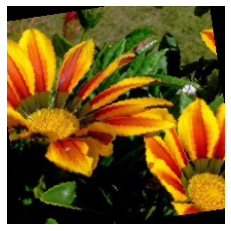

In [ ]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Grab images and labels from trainloader
images, labels = next(iter(dataloaders['train'])) 

# labels returns the value - which is just index of the key class in the dictionary
# Use the value index to get key value then search cat_to_name
helper.imshow(images[0], title=labels[0], normalize=True)

# Grab classmap from trainload
# Find the key, based on value - which is just key index 
# The key from the class map is used in cat_to_name to get the correct corresponding name  for each flower
class_map = dataloaders['train'].dataset.class_to_idx 
index = [* class_map][labels[0].item()]
cat_to_name[index]

In [ ]:
[* class_map][0]

'1'

In [ ]:
cat_to_name[index]

32

In [ ]:
# TODO: Save the checkpoint 
def save_model(model, optimizer,needed_epochs, model_params = None, exp_lr_scheduler=None):
    
    parent_path = Path(Path.cwd(), model.name + "_checkpoints")
    if Path.exists(parent_path) == False:
        Path.mkdir(parent_path)
    
    ts = datetime.datetime.fromtimestamp(time.time()).strftime('%H:%M:%S')
    file_name= "checkpoint" + ts +".pth"
    model = model.to('cpu')
    
    checkpoint = {'fc' : model.fc,
                  'optimizer' : optimizer.state_dict(),
                  'model_params' : model_params,
                  'exp_lr_scheduler' : exp_lr_scheduler.state_dict(),
                  'epochs' : needed_epochs,
                  'state_dict': model.state_dict()}
    
    torch.save(checkpoint, Path(parent_path, file_name))

# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_model(checkpoint_path, Display=False):
    """ Loads the define model with saved weights.
        
        model: Model object
        best_model_wts: The model's state_dict()
        
        Returns model with loaded weights.
    """
    if Path.exists(Path(checkpoint_path)) == False:
        print("Faulty path to checkpoint")
        return None
    
    map_location = ("cuda:0" if torch.cuda.is_available() else "cpu")
    checkpoint = torch.load(checkpoint_path, map_location)

    model =  models.resnet152(pretrained=False)
    for param in model.parameters():
        param.requires_grad = False

    model.fc = checkpoint['fc']
    
    if Display:
        print(f"Optimizer: {checkpoint['optimizer']}")
        print(f"Epochs needed: {checkpoint['epochs']}")
    
    model.load_state_dict(checkpoint['state_dict'])
    return model
    


def log_params(data=None, file_path='paramLog.csv', columns=['accuracy',  'testing_loss', 'base_model','added_arc', 'epochs', 'batch_size', 'optimizer', 'init_lr' ]):
    """
    Use to save hyper parameters in Excel for future reference
    
    data: Hyper parameter Infomation for future reference and comparison
    file_path: desired path to save Excel file
        By default saves to 'paramLog.xlsx' in current directory
        
    columns: reference labels for records in the Excel file  
        By default ['accuracy', 'testing_loss',  'base_model','added_arc', 'epochs' ,  'batch_size', 'optimizer', 'init_lr' ]
    """
    if data.shape != (1, len(columns)):
        if data is None:
            data = np.arange(len(columns))
        data = np.reshape(data, (1, len(columns)))
    
    # Create dataframe if spreadsheet doesn't exist 
    if Path.exists(Path(file_path)) == False:
        param_log = pd.DataFrame(data, columns=columns)
        print(f"{param_log}")
        pd.DataFrame.to_csv(param_log, file_path, columns=columns, index=False) 
    else: 
        # Otherwise load the existing data
        param_log = pd.read_csv(file_path)
        pd.DataFrame.to_csv(param_log, file_path, header=False, index=False, mode='a') 
    
    if Path.exists(Path(file_path)): 
        print(f"Hyper Parameters have been written to {file_path}")

def train_model(model, criterion, optimizer, scheduler, num_epochs=30):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    model.name = re.split("\(\n", str(model), 1)[0]
    optimizer_name = re.split(' ', str(optimizer), maxsplit=1)[0]
    init_lr = optimizer.param_groups[0]['lr']
    batch_size = dataloaders['train'].batch_size
    added_layers = model.fc
    
    train_log = ""
    training_epoch_time = 0
    
    for epoch in range(num_epochs):
        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            epoch_since = time.time()
            
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        scheduler.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            epoch_time = epoch_since - time.time()
            
            if phase == 'train':
                linebrk = '='
                training_epoch_time = epoch_time
                print(f"{linebrk * 125}", f"\nEpoch: {epoch + 1}/{num_epochs} \t{phase} Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}")
            else:
                epoch_time += training_epoch_time
                print(f"\t\t{phase} Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f} \t {epoch_time // 60:.0f}m {epoch_time % 60:.0f}")
            
            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                needed_epochs = epoch
                
                best_model_wts = copy.deepcopy(model.state_dict())
                print(f"Validation accuracy increased ({best_acc:.6f} --> {epoch_acc:.6f}).  Saving model ...")
                model_params = np.array([best_acc, epoch_loss, model.name, 
                                        added_layers, needed_epochs, batch_size ,optimizer_name , init_lr], dtype=object)
                

    time_elapsed = time.time() - since
    
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    log_params(model_params)
    # load best model weights
    model.load_state_dict(best_model_wts)
    save_model(model, optimizer, needed_epochs, model_params, exp_lr_scheduler)
    return model

In [ ]:
# Let's try ResNet-152 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
res152 = torchvision.models.resnet152(pretrained=True)
res152.name = "ResNet"



# TODO: Build and train your network
# Freeze learned parameters on each layer
for params in res152.parameters():
    params.requires_grad = False

# Change the last layer according to our needs
from collections import OrderedDict
res152.fc = nn.Sequential(OrderedDict([
        ('fc1', nn.Linear(2048, 1000, bias=True)),
        ('fc1_relu', nn.Tanh()),
        ('dropout1', nn.Dropout(p=.20)),
        ('fc2', nn.Linear(1000, 102, bias=True))
     ]))

train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    print(f"Moving {res152.name} model to gpu {device}")
    res152.cuda(device)
else:
    print("Your model is on the cpu")


epochs = 30 
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(res152.fc.parameters(), lr=0.01)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# res152 = train_model(res152, criterion, optimizer, exp_lr_scheduler, epochs)


    
  

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

Moving ResNet model to gpu cuda:0


In [ ]:
save_model(res152, optimizer, 21, exp_lr_scheduler=exp_lr_scheduler)

In [ ]:
# model2 = torch.nn
model2 = load_model("/content/gdrive/MyDrive/Kaggle/ResNet_checkpoints/checkpoint03:27:53.pth")
model2

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model
    
        image: PIL image to be prepped for pytorch model
        Returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    # Resize the image
    new_size = 256
    width, height = image.size
    aspect_ratio = width // height
    width = new_size * aspect_ratio
    height = new_size

    image = image.resize((width, height))
    
    # Crop Center 
    new_width = new_height = 224
    left = (width - new_width)/2
    top = (height - new_height)/2
    right = (width + new_width)/2
    bottom = (height + new_height)/2

    image = image.crop((left, top, right, bottom))
    
    # Convert pil image to numpy array and reduce channel infomation
    np_image = np.array(image) / 255

    # Normalize the image
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    np_image = (np_image - mean) / std
    
    # Reorder the color channel as first dimension
    np_image = np.transpose(np_image, (2, 0, 1))
    
    image = torch.from_numpy(np_image)
    
    return image


def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = ((std * image)) + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    try:
        class PathError(Exception):
            pass

        if Path.exists(Path(f"{image_path}")) == False:
            raise PathError()
        
        # Preprocess image
        img = Image.open(image_path)
        img = process_image(img)
        img = img.view( -1 , *img.shape)
        print(f"Image shape : {img.shape}")
        
        # Use model for inference
        # set to eval mode
        model.eval()
        with torch.no_grad():
            # Send image to device
            # Forward pass through model
            # Get a ranked prob/classes
            img = img.to(dtype= torch.float, device=device)
            output = model(img)
            prob, classes = torch.topk(output, topk, dim=1)
        return prob, classes
        
        
    except PathError as err:
        print(f"{image_path} is faulty. Try a different path {err}")
        raise
        
    
    # TODO: Implement the code to predict the class from an image file

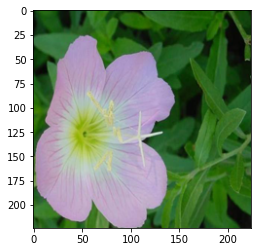

In [ ]:
image = Image.open("test_image.jpg")
image = process_image(image)
imshow(image)

In [ ]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
prob, classes = predict("test_image.jpg", res152)
prob, classes

Image shape : torch.Size([1, 3, 224, 224])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


(tensor([[0.4077, 0.3942, 0.3202, 0.3141, 0.2624]]),
 tensor([[88, 11, 52, 81, 23]]))

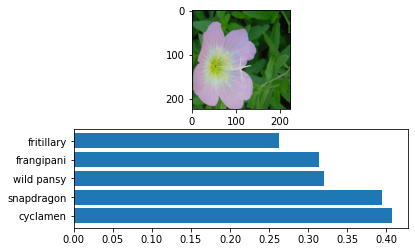

In [ ]:
# TODO: Display an image along with the top 5 classes
prob, classes = prob.to('cpu'), classes.to('cpu')

cls_name = np.array(classes, dtype=str)
cls_name = [cat_to_name[x.item()] for x in np.nditer(cls_name)]

figure, ax = plt.subplots(2,1)
plt.subplot(2, 1, 1)
imshow(image, plt)
plt.subplot(2, 1, 2)
plt.barh(cls_name, prob.numpy()[0])
plt.show()